In [1]:
#import packages
import copy
import datetime
import pandas as pd
import numpy as np
import scipy

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style( 'whitegrid' )

# Parameters

In [3]:
pm = {
    'h_range': [ 2, 4, 7, 14, 30 ],
}

# Load Data

In [4]:
# Market data
markets = pd.read_csv( '../data/train/markets.csv', )
markets['Date'] = pd.to_datetime( markets['Date'], utc=True )
markets.set_index( 'Date', inplace=True )

In [5]:
# Media
media = pd.read_csv( '../data/train/media.csv', parse_dates=[ 'pub_date', ], index_col='pub_date'  )
if 'Unnamed: 0' in media.columns:
    media.drop( 'Unnamed: 0', axis=1, inplace=True )

In [6]:
# Combined
markets_and_media = markets.join( media, how='outer', )
# Denote origin
markets_and_media['market_or_media'] = 'market'
markets_and_media.loc[markets_and_media['Close'].isna(),'market_or_media'] = 'media'

# Calculate Derived Features

## Markets

In [7]:
for h in pm['h_range']:
    markets_roll = markets.rolling( pd.Timedelta( h, 'days' ) )
    markets['DeltaAdjClose{}'.format( h )] = markets_roll['AdjClose'].apply( lambda window: window[-1] - window[0], )
    markets['SigmaAdjClose{}'.format( h )] = markets_roll['AdjClose'].std()

In [8]:
markets['logVolume'] = np.log10( markets['Volume'] )

In [9]:
markets['DiffOverDay'] = markets['AdjClose'] - markets['Open']

In [10]:
markets['DaysFromStart'] = ( markets.index - markets.index[0] ).days

## Combined

In [11]:
# Count the number of articles published within h_pub days into the future, using the market's dates
for h in pm['h_range']:
    mam_reverse_roll = markets_and_media[::-1].rolling( pd.Timedelta( h, 'days' ) )
    markets['ArticleCount{}'.format(h)] = mam_reverse_roll['abstract'].count()

# Visualize

## Markets

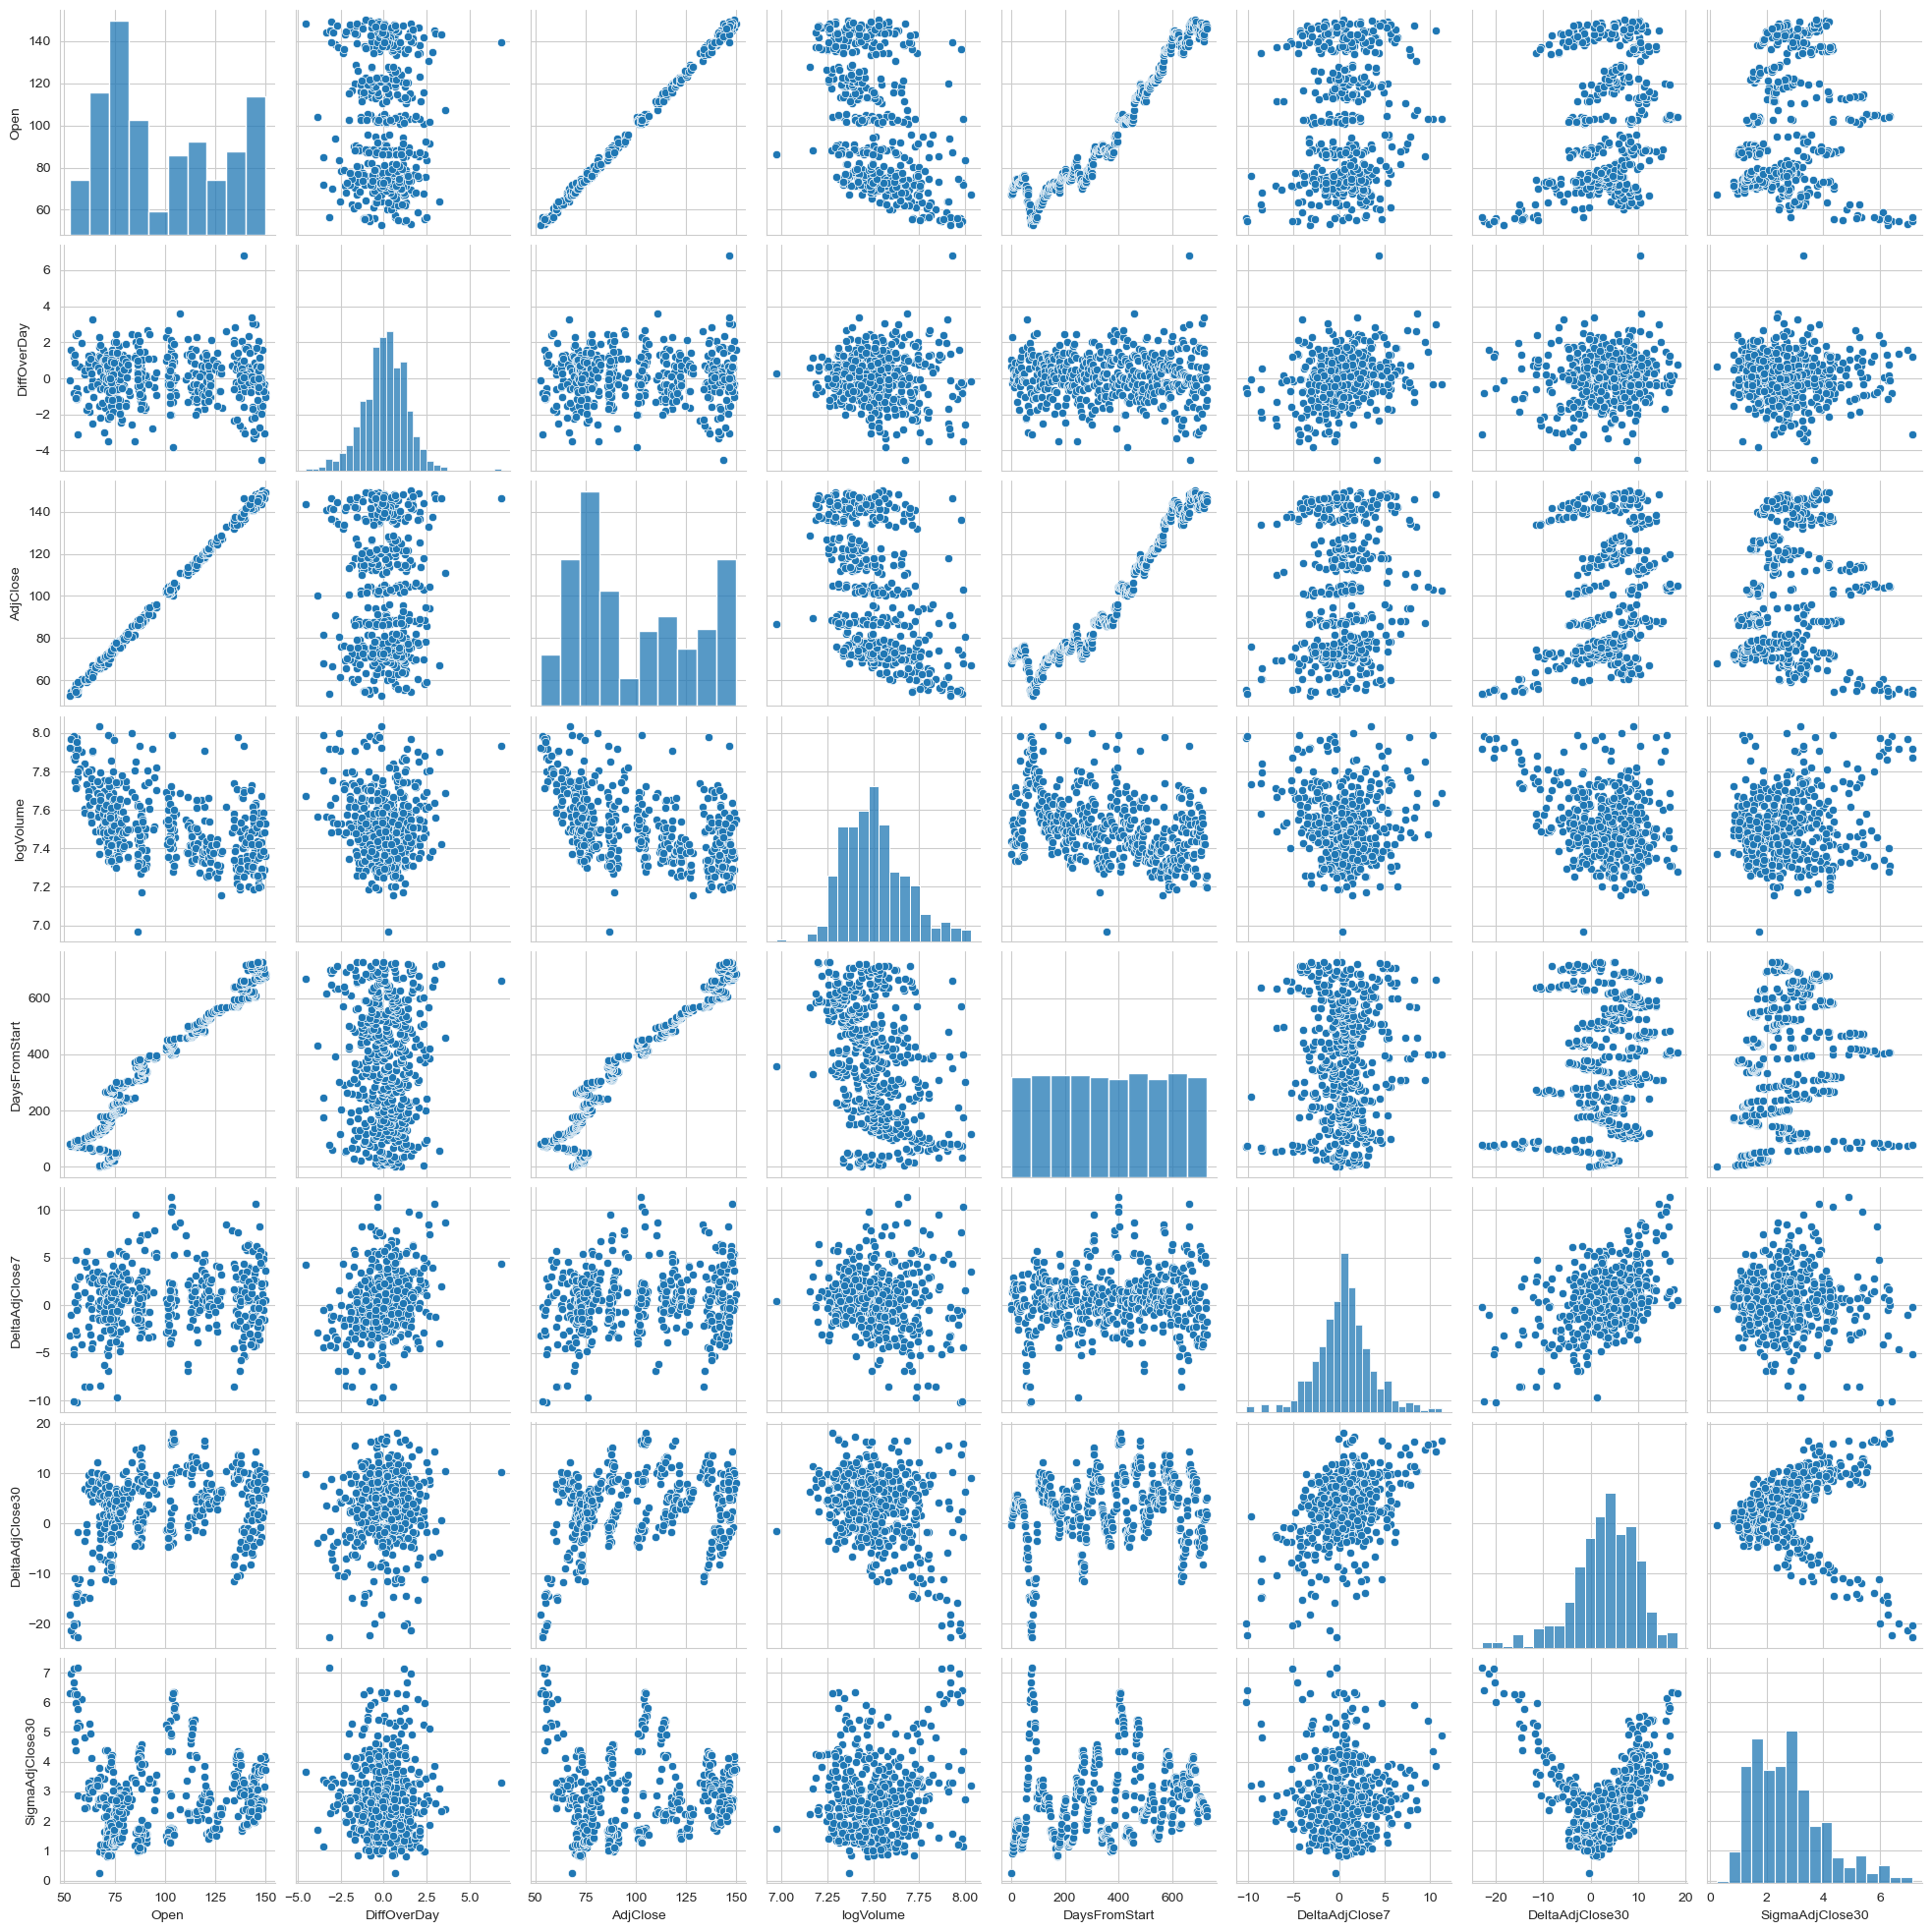

In [12]:
sns.pairplot(
    data = markets,
    vars = [ 'Open', 'DiffOverDay', 'AdjClose', 'logVolume', 'DaysFromStart', 'DeltaAdjClose7', 'DeltaAdjClose30', 'SigmaAdjClose30' ],
)


## Media

<Axes: xlabel='pub_date', ylabel='relevance_rank'>

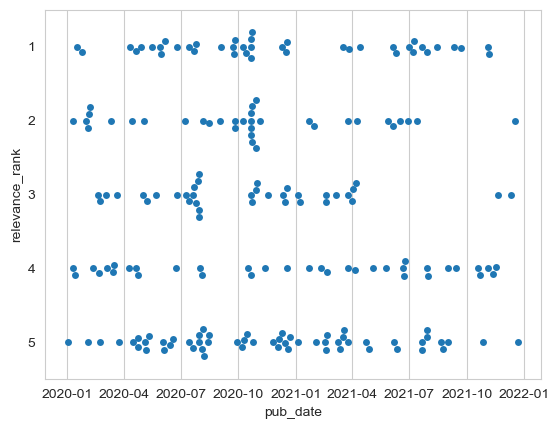

In [13]:
fig = plt.figure()
ax = plt.gca()

sns.swarmplot(
    data = media,
    x = media.index,
    y = media['relevance_rank'],
    orient = 'horizontal',
    ax = ax,
)

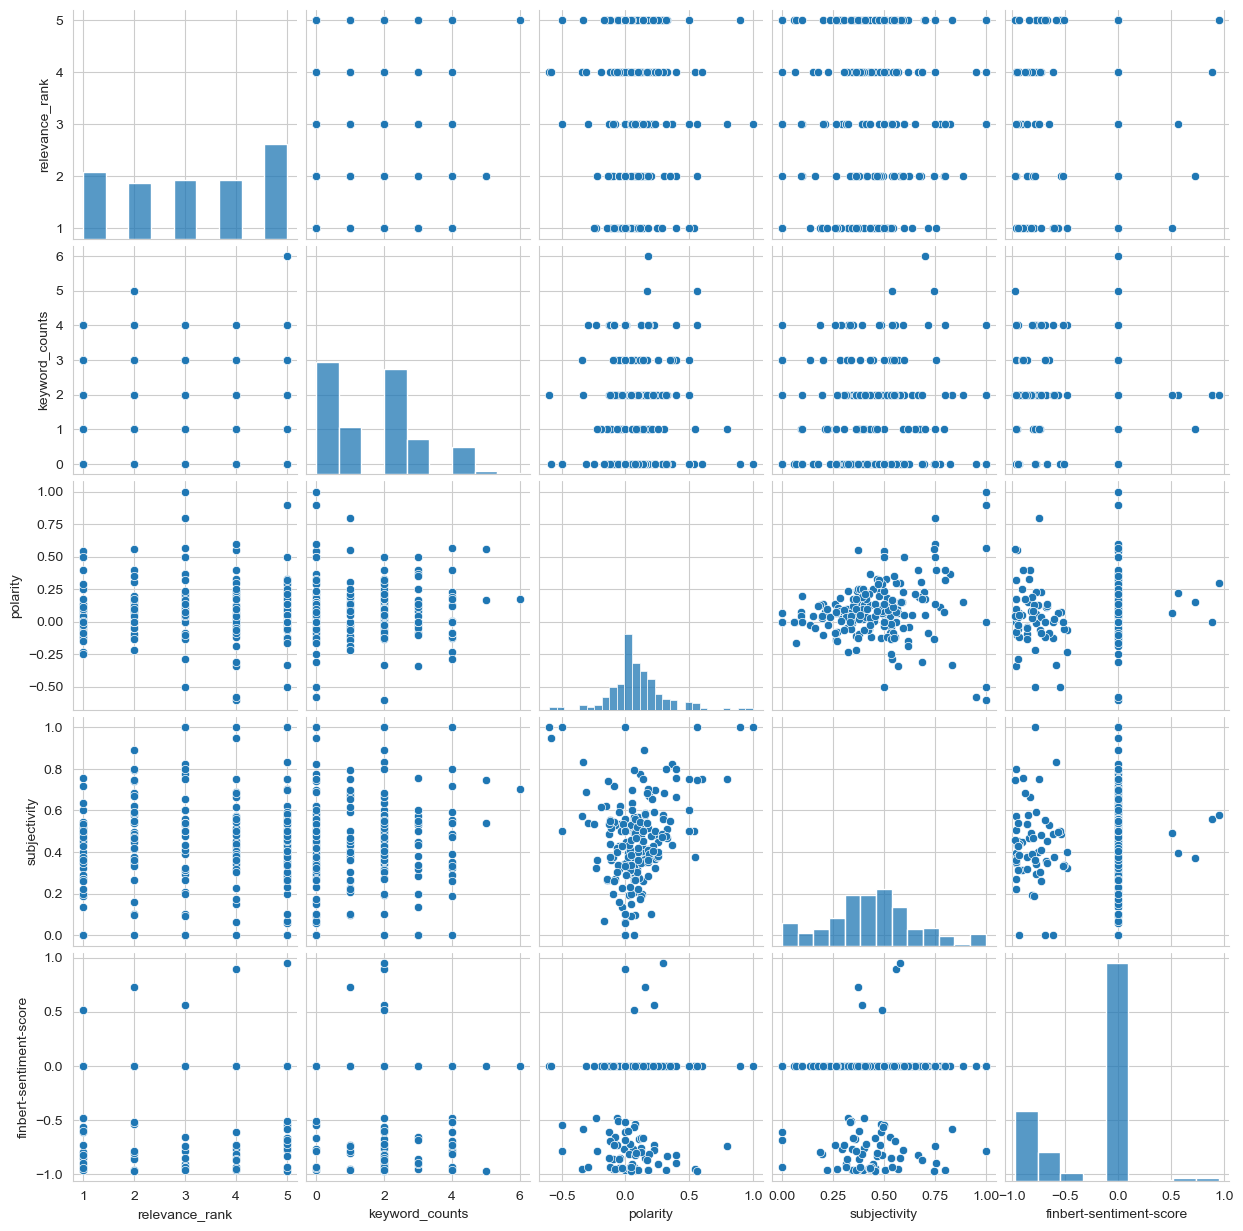

In [14]:
sns.pairplot(
    data = media,
    # vars = [ 'word_count', 'relevance_rank', 'keyword_counts', 'polarity', 'subjectivity', 'finbert-sentiment-score' ],
    vars = [ 'relevance_rank', 'keyword_counts', 'polarity', 'subjectivity', 'finbert-sentiment-score' ],
    # kind = 'hist',
)

# Save Data

In [15]:
markets.to_csv( '../data/train/markets_processed.csv' )
media.to_csv( '../data/train/media_processed.csv' )
markets_and_media.to_csv( '../data/train/combined.csv' )